# iPRules

# Statics

In [1]:
import dask.dataframe as dd
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import metrics


## Load Dataset

In [2]:

from notebooks.IPRules.read_datasets import read_dataset
dataset_names = [
    "divorce",
    "kr-vs-kp",
    "australian",
    "criotherapy",
    "data_banknote_authentication",
    "haberman",
    "mammographic_masses",
    "segmentation",
    "tic-tac-toe",
    "wisconsin",
    "salud-covid",
    "SPECT",
    "ionosphere",
    "connect-4",
    "credit"
]
filename = "connect-4"
#filename = "divorce"
test_size=0.1
path = f'../..'
dataset_path_name = f'{path}/data/{filename}.csv'
X, y, dataset, target_value_name, pandas_dataset = read_dataset(filename, dataset_path_name)

pandas_dataset.head()

,F1_b,F1_o,F1_x,F2_b,F2_o,F2_x,F3_b,F3_o,F3_x,F4_b,...,F40_b,F40_o,F40_x,F41_b,F41_o,F41_x,F42_b,F42_o,F42_x,Class
0,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
1,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
2,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
3,True,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True
4,False,True,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True


In [3]:
#Define dataset
X_train, X_test, y_train, y_test = train_test_split(dataset.data, dataset.target, test_size=test_size, random_state=1)
encoded_train_pandas_dataset = pd.DataFrame(data= np.c_[X_train, y_train], columns= list(dataset['feature_names']) + [target_value_name])
encoded_test_pandas_dataset = pd.DataFrame(data= np.c_[X_test, y_test], columns= list(dataset['feature_names']) + [target_value_name])
print('Sizes (without target):')
print(f'Original size {dataset.data.shape}')
print(f'Train size {X_train.shape}')
print(f'Test size {X_test.shape}')
print(f'encoded_train_pandas_dataset size {encoded_train_pandas_dataset.shape}')
print(f'encoded_test_pandas_dataset size {encoded_test_pandas_dataset.shape}')

Sizes (without target):
Original size (67557, 126)
Train size (60801, 126)
Test size (6756, 126)
encoded_train_pandas_dataset size (60801, 127)
encoded_test_pandas_dataset size (6756, 127)


## Define Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, make_scorer, recall_score, accuracy_score

# Define scorer
ensemble = RandomForestClassifier(n_estimators=100, criterion="gini")
ensemble.fit(X_train, y_train)

RandomForestClassifier()

## iPRules

->Extract feature importance list


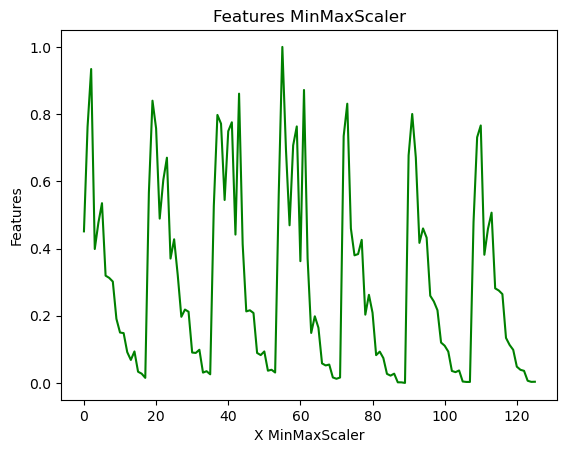

	 Original features 126
	 Selected features 117
	 Percentage of selected rules: 92.85714285714286 %
->Generate new tree based on list
Elapsed time to compute the binary_tree_generator: 13308.776 seconds
->Generate obtained patterns tree
Elapsed time to compute the obtain_pattern_list_of_valid_nodes_with_pvalue: 362.060 seconds
->Categorize patterns
Elapsed time to compute the categorize_patterns: 66.264 seconds
->Prune Rules
Elapsed time to compute the prune_rules: 11.764 seconds
Elapsed TOTAL TIME: 13749.373 seconds


In [5]:
from iPRules.iPRules import iPRules

import time
start_time = time.time()
rules = iPRules(
                feature_names=dataset.feature_names,
                target_value_name = dataset.target_names,
                display_features = True,
                display_logs = True,
                chi_square_percent_point_function = 0.95,
                scale_feature_coefficient = 0.01,
                min_accuracy_coefficient = 0.9,
                min_number_class_per_node = 3
            )
# Fit model
rules.fit(encoded_train_pandas_dataset, ensemble.feature_importances_)

elapsed_time = time.time() - start_time
print(f"Elapsed TOTAL TIME: {elapsed_time:.3f} seconds")

# Print Model

In [6]:
print(rules)

> ++++++++++++++++++++++++++++
> iPRules --  Number of Rules 1108:
> iPRules --  Number of Minimal Rules 1079:
> ++++++++++++++++++++++++++++
> ------------------------------
 ** Target value: True ** Target: 9 ** Total: 10 ** Accuracy: 0.9 ** Complexity: 22 ** Chi2 critical_value: 3.841458820694124 ** P_value: 0.00126015313761034
	 Query: F19_o == True  &  F1_x == True  &  F21_o == False  &  F15_o == False  &  F7_o == True  &  F25_o == False  &  F31_o == False  &  F13_o == False  &  F14_x == False  &  F13_x == True  &  F37_x == False  &  F20_x == False  &  F1_o == False  &  F7_x == False  &  F14_o == False  &  F25_b == True  &  F37_o == True  &  F20_o == False  &  F19_x == False  &  F31_b == True  &  F31_x == False  &  F8_x == True
> ------------------------------
> ------------------------------
 ** Target value: True ** Target: 9 ** Total: 10 ** Accuracy: 0.9 ** Complexity: 20 ** Chi2 critical_value: 3.841458820694124 ** P_value: 1.419512909221566e-08
	 Query: F19_o == True  &  F1_x

# Predict

In [7]:
# ENSEMBLE
y_pred_test_ensemble = ensemble.predict(X_test)

# RULES
y_pred_test_rules = rules.predict(X_test, sorting_method="target_accuracy")

In [8]:
# CATEGORIZABLES
np_array_rules = np.array(y_pred_test_rules)
#not_filter_indices = np.where(np.logical_and(np_array_rules != 0, np_array_rules!=1))[0]
filter_indices = np.where(np_array_rules != None)[0]


np_filterred_y_test = np.array(y_test)[filter_indices]
np_filterred_y_pred_test_ensemble = np.array(y_pred_test_ensemble)[filter_indices]
np_filterred_y_pred_test_rules = np.array(y_pred_test_rules)[filter_indices]
# CHANGE FORMAT IN ORDER TO NOT HAVE PROBLEMS
np_filterred_y_pred_test_rules = np_filterred_y_pred_test_rules.astype('int64')


print(f'DATASET TEST: {len(y_test)}')
print(f'DATASET TEST categorizable: {len(np_filterred_y_test)}')
print('Cobertura:',str("{:.2f}".format(100*(len(np_filterred_y_pred_test_rules)/len(y_test))))+'%')

ensemble_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF accuracy:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
ensemble_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_ensemble)
print('RF F1-score:',str("{:.2f}".format(100*ensemble_accuracy))+'%')
rules_accuracy = metrics.accuracy_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules Accuracy:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.f1_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules F1-score:',str("{:.2f}".format(100*rules_accuracy))+'%')
rules_accuracy = metrics.roc_auc_score(np_filterred_y_test, np_filterred_y_pred_test_rules)
print('Rules roc_auc_score:',str("{:.2f}".format(100*rules_accuracy))+'%')


DATASET TEST: 6756
DATASET TEST categorizable: 3070
Cobertura: 45.44%
RF accuracy: 93.39%
RF F1-score: 95.83%
Rules Accuracy: 92.35%
Rules F1-score: 95.20%
Rules roc_auc_score: 85.98%


# SHAP explainer

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/re

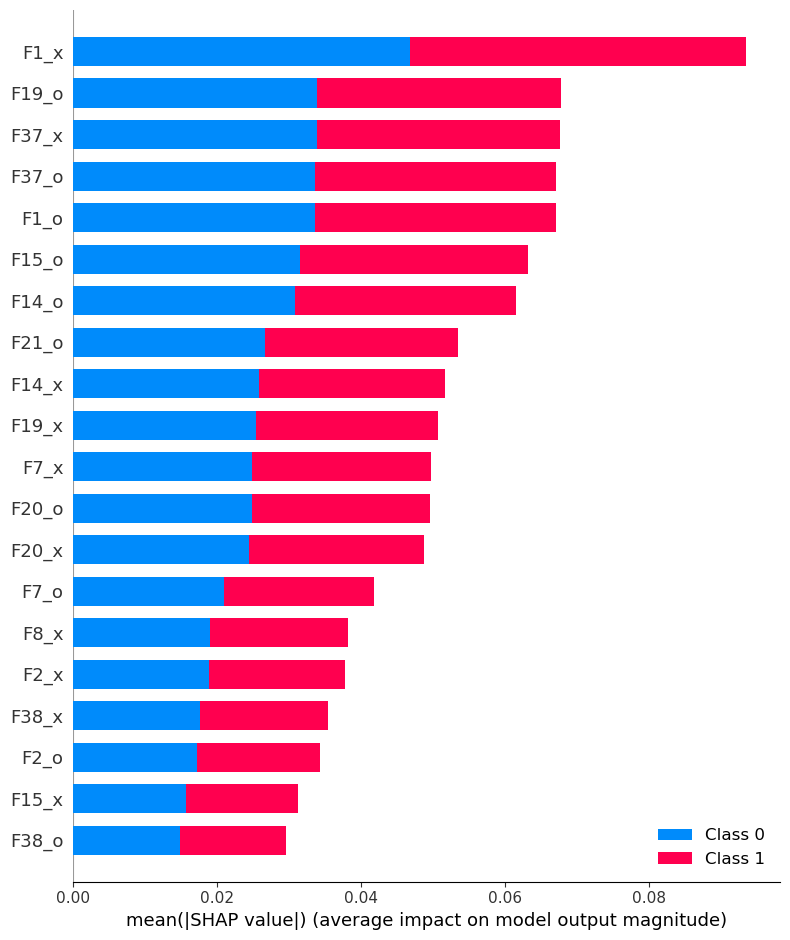

In [9]:
import shap

# Create Tree Explainer object that can calculate shap values
explainer = shap.TreeExplainer(ensemble)

# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names)


In [10]:

shap.summary_plot(shap_values, X_train, feature_names=dataset.feature_names, plot_type="dot")

AssertionError: Only plot_type = 'bar' is supported for multi-output explanations!